# 8. Chapter 3: Descriptions of Destinations

The code chunks below should follow the approximate order of the chapter.


In [1]:
import plotly.express as px
import pandas as pd
import glob
import os
import re
import numpy as np

In [2]:
modelBasePath = 'python_resources\\tucode\\inprogress\\chapter2\\modeloutput\\finalmodels\\'


In [3]:
# make a df into a visualization

def makefig(df):
    
    df["realclass"] = df["realclass"].astype(str)
    df['realclass'] = df['realclass'].str.replace('0','other category').str.replace('1', 'travel')
    
    fig = px.scatter(df, x='pubdate', y='logistic',
                 symbol = df['realclass'],
                 symbol_map = {"travel": "circle", "other category": "triangle-down"},
                 color_discrete_map={'travel':'blue', 'other category': "red"},
                 color='realclass', hover_data=['title', 'volid'])
    return fig

In [4]:
def compTotals(file):

    dforig = pd.read_csv(file, index_col=0, encoding='utf8')
    df = (dforig*100).copy()  
    
    # Extract unique column names without numbers
    unique_columns = set([re.sub(r'(_[0-9]+)?$', '', item) for item in df.columns.to_list()])
    unique_columns
    
    # Create a DataFrame with average values for each unique combination of columns
    average_df = pd.DataFrame()
    
    for col in unique_columns:
        if col == 'gender_gender_au':
            
            relevant_columns = [c for c in df.columns if c.startswith('gender_gender_au') and 'vs_non' not in c]
            
            # Calculate the average along columns
            average_values = df[relevant_columns].mean(axis=1)
            #print(average_values)
    
            # Add the result to the new DataFrame
            average_df[col] = average_values
            #print('gender is done')
               
        
        
        elif col != 'gender_gender_au':
            #print('not gender!')
            # Extract columns with the current prefix
            relevant_columns = [c for c in df.columns if c.startswith(col)]
                
            # Calculate the average along columns
            average_values = df[relevant_columns].mean(axis=1)
            #print(average_values)
        
            # Add the result to the new DataFrame
            average_df[col] = average_values

    # We may still have some index entries that have multiple versions
    # so let us do some grouping
    
    # create a category, based in the index, to do grouping
    average_df['Model'] = average_df.index
    
    # Extract the common part of the indices without numbers
    average_df['Model'] = average_df['Model'].apply(lambda x: re.sub(r'(_[0-9]+)?$', '', x))
    
    # Group by the 'Group' column to combine the multiple iterations
    # and calculate the mean
    averages = average_df.groupby('Model').mean()
    
    return averages.round(1)

def compTotalsWithList(file):
    dforig = pd.read_csv(file, index_col=0, encoding='utf8')
    df = (dforig*100).copy()  
    
    # Extract unique column names without numbers
    unique_columns = set([re.sub(r'(_[0-9]+)?$', '', item) for item in df.columns.to_list()])
    unique_columns
    
    # Create a DataFrame with average values for each unique combination of columns
    average_df = pd.DataFrame()
    
    for col in unique_columns:
        if col == 'gender_gender_au':
            
            relevant_columns = [c for c in df.columns if c.startswith('gender_gender_au') and 'vs_non' not in c]
            
            # Calculate the average along columns
            average_values = df[relevant_columns].mean(axis=1)
            #print(average_values)
    
            # Add the result to the new DataFrame
            average_df[col] = average_values
            #print('gender is done')
               
        
        
        elif col != 'gender_gender_au':
            #print('not gender!')
            # Extract columns with the current prefix
            relevant_columns = [c for c in df.columns if c.startswith(col)]
                
            # Calculate the average along columns
            average_values = df[relevant_columns].mean(axis=1)
            #print(average_values)
        
            # Add the result to the new DataFrame
            average_df[col] = average_values

    # We may still have some index entries that have multiple versions
    # so let us do some grouping
    
    # create a category, based in the index, to do grouping
    average_df['Model'] = average_df.index
    
    # Extract the common part of the indices without numbers
    average_df['Model'] = average_df['Model'].apply(lambda x: re.sub(r'(_[0-9]+)?$', '', x))
    
    result_df = average_df.groupby('Model').agg(lambda x: x.dropna().round(1).tolist()).reset_index()
    
    return result_df

def compTotalsStdDev(file):
    result_df = compTotalsWithList(file)
    
    std_dev_df = result_df.set_index('Model')
    
    std_dev_df = std_dev_df.map(lambda x: np.std(x) if len(x) > 0 else np.nan)

    return std_dev_df
    


# Big Picture: Travel Writing Against the Eighteenth Century


In [5]:
bibSourceList = ['cox',  'brynmawr',  'ncco_c19trav',  'btw_w',
 'murray',  'leask', 'gove',  'tee',
 'btw_europe',  'andrews',  'bdanth', 'irishmcveagh',
 'robinson_w',  'ncco_travelnarr']
bibSourceList.sort()

genList = ['alltravel','lcsh_traveltag']

In [6]:
def accuracy_summary(folder_path):
    # Use os.path.join to create the complete path
    search_pattern = os.path.join(folder_path, '**\\**', '*_resultsummary.txt')

    # Use glob to find files matching the pattern
    result_files = glob.glob(search_pattern, recursive=True)
    result_files = [x for x in result_files if 'paceofchange' not in x]
    result_files = list(set(result_files))

    # Extract filenames before '_resultsummary.txt'
    file_info = [(os.path.splitext(os.path.basename(file))[0].rsplit('_resultsummary', 1)[0], file) for file in result_files]
    
    # create a list to hold dfs
    compList = []
    
    for source, path in file_info:
        compdf = pd.read_csv(path, sep=':', names = ['category', source])
        compdf.set_index('category', inplace=True)
        compList.append(compdf)
        
    finalCompdf = pd.concat(compList, axis=1).round(2)
    
    ### Now, we'll just take the average of the best accuracies
    
    # Extract the 'bestaccuracy' row
    accRow = finalCompdf.loc['bestaccuracy']

    averagebibsdf = pd.DataFrame({'index': accRow.index, 'bestaccuracy': accRow.values})

    # Group by the 'index' column and aggregate the 'bestaccuracy' values with commas
    averagebibsdf = averagebibsdf.groupby('index')['bestaccuracy'].agg(lambda x: ', '.join(map(str, x))).reset_index()

    # Split the 'bestaccuracy' values into a list of floats
    averagebibsdf['bestaccuracy'] = averagebibsdf['bestaccuracy'].apply(lambda x: [float(val) for val in x.split(', ')])
    
    # Calculate the average of the 'bestaccuracy' values for each row
    averagebibsdf['average_bestaccuracy'] = averagebibsdf['bestaccuracy'].apply(lambda x: sum(x) / len(x))

    # rename
    # if you want, you can return just the below
    averagebibsdf = averagebibsdf.rename(columns={'index': 'category'})
    averagebibsdf['average_bestaccuracy'] = (averagebibsdf['average_bestaccuracy']*100).round(2)

    
    # if you want to add a column for how many files there were in each sample
    sumNames = ['True positives ', 'True negatives ', 'False positives ', 'False negatives ']
    tempdf = finalCompdf[finalCompdf.index.isin(sumNames)]
    total_files_row = pd.Series(tempdf.sum(axis=0)/2, name='total files')
    # Append the 'total files' row to the original DataFrame
    finalCompdf = pd.concat([finalCompdf, total_files_row.to_frame().T])
    # Create a DataFrame containing only the 'total files' row
    filesdf = finalCompdf[finalCompdf.index == 'total files'].copy()
    # Drop duplicate columns
    filesdf = filesdf.loc[:, ~filesdf.columns.duplicated()].T

    resultDF = pd.merge(filesdf, averagebibsdf, left_index=True, right_on='category')
    resultDF = resultDF[[col for col in resultDF.columns if col != 'total files'] + ['total files']]
    resultDF = resultDF.round(1)

    resultDF.rename(columns={'category': 'Model'}, inplace=True)

    return resultDF

In [7]:
allaccdf = accuracy_summary(modelBasePath).sort_values('average_bestaccuracy')

In [8]:
allaccdf[allaccdf.Model.isin(bibSourceList + ['alltravel', 'lcsh_traveltag', 'origbib', 'lcsh_source'])]

Model        bestaccuracy  average_bestaccuracy  total files
34  ncco_travelnarr    [0.7, 0.9, 0.85]                  81.7         10.0
6               cox  [0.87, 0.88, 0.87]                  87.3        300.0
0         alltravel  [0.88, 0.86, 0.88]                  87.3        300.0
38          origbib  [0.88, 0.86, 0.89]                  87.7        300.0
17      lcsh_source  [0.89, 0.88, 0.88]                  88.3        300.0
19   lcsh_traveltag     [0.9, 0.9, 0.9]                  90.0        300.0
12     irishmcveagh    [0.9, 0.94, 0.9]                  91.3         55.0
5             btw_w  [0.92, 0.92, 0.91]                  91.7        152.0
20            leask  [0.93, 0.91, 0.94]                  92.7         96.0
4        btw_europe  [0.93, 0.93, 0.93]                  93.0         74.0
1           andrews  [0.94, 0.92, 0.93]                  93.0         63.0
32           murray  [0.94, 0.93, 0.94]                  93.7        118.0
33     ncco_c19trav  [0.94, 0.94, 0.93]                  93.7        180.0
10             gove  [0.95, 0.93, 0.94]                  94.0         85.0
39       robinson_w  [0.94, 0.92, 0.96]                  94.0         45.0
2            bdanth  [0.93, 0.93, 0.96]                  94.0         60.0
3          brynmawr  [0.95, 0.94, 0.94]                  94.3        243.0
40              tee  [0.96, 0.96, 0.95]                  95.7         81.0

In [9]:
# Replace 'your_folder_path' with the actual path to your folder
# folder_path = modelBasePath + your_folder_path

# folder_path = modelBasePath + 'gender//'
# test = accuracy_summary(folder_path)
# test

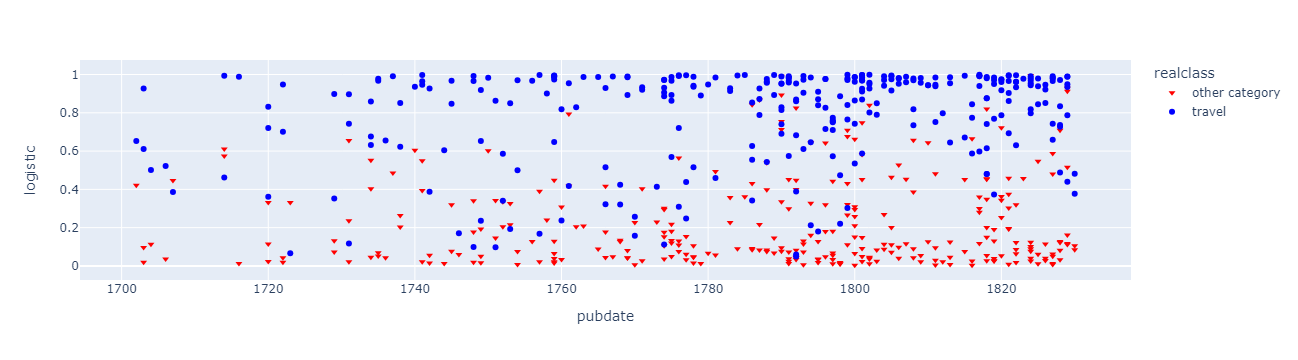

In [10]:
df = pd.read_csv(modelBasePath + '\\allbibs\\allbibs.1\\alltravel.csv')
makefig(df)

In [11]:
# df = pd.read_csv(modelBasePath + 'allbibs.2\\alltravel.csv')
# makefig(df)

In [12]:
# df = pd.read_csv(modelBasePath + 'allbibs.3\\alltravel.csv')
# makefig(df)

## Bibliographical Sources Perspectives on Each Other
The percentages in Fig.X (the chart above) are telling insofar as they can indicate how much the models can tell them apart from the rest of the corpus. But if we’re thinking about comparisons, a similar approach can show how similar the different perspectives of travel writing are to each other, despite their differences. 

In [13]:
# # Entire multicomp, done with version 1 of all models
# compTotalsdf = pd.read_csv(modelBasePath + 'comparisonTotals.csv')
# compTotalsdf.set_index('Unnamed: 0', inplace=True)
# compTotalsdf.sort_index(axis=1, inplace=True)
# compTotalsdf = compTotalsdf.rename_axis('category')
# compTotalsdf = compTotalsdf.round(3)*100
# compTotalsdf.sort_index(inplace=True)

In [14]:
# Let's compute all the comparison dfs here!
# note that I rename some categories, etc
# in part, this is because I don't want to go back into the code
# but it might also be useful for folks viewing the original data
# so beware if you are using differently named files, etc!
def organizedf(df):
    df.index = df.index.str.replace(r'^[^_]+_', '', regex=True)
    df.columns = df.columns.str.replace(r'^[^_]+_', '', regex=True)
    df.sort_index(axis=0, inplace=True)
    df.sort_index(axis=1, inplace=True)
    colList = df.columns.tolist()
    colList = [x for x in colList if x != 'category']
    for col in colList:
        df.loc[col, col] = np.nan
    return df

compTotalsdf = compTotals(modelBasePath+'\\mutual recognition\\comparisonTotals.csv')
compTotalsdf = organizedf(compTotalsdf)

compTotalsdfList = compTotalsWithList(modelBasePath+'\\mutual recognition\\comparisonTotals.csv')
compTotalsdfList = compTotalsdfList.set_index('Model')
compTotalsdfList = organizedf(compTotalsdfList)

compTotalsdfStd = compTotalsStdDev(modelBasePath+'\\mutual recognition\\comparisonTotals.csv')

compTotalsdfStd = organizedf(compTotalsdfStd)


In [15]:
# an average isn't especially useful - 
# it depends on what I'm including
# for example, not all of the models are trained against nontravel (gender_au_vs_non)
compTotalsdf.loc[bibSourceList, bibSourceList].mean().sort_values().mean()

82.6120879120879

In [16]:
# compTotalsdf

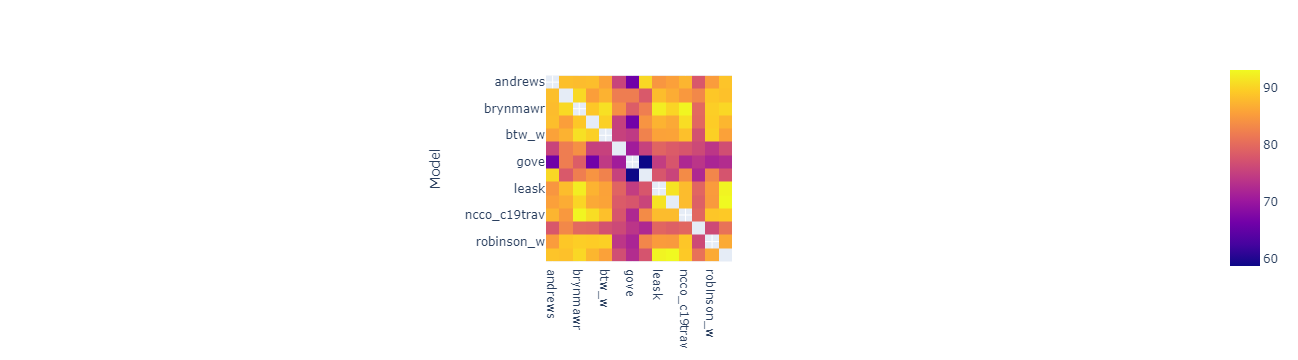

In [17]:
bibcompTotals = compTotalsdf.loc[bibSourceList, bibSourceList]
fig = px.imshow(bibcompTotals)

fig.show()

In [18]:
bibcompTotals

andrews  bdanth  brynmawr  btw_europe  btw_w   cox  gove  \
Model                                                                       
andrews              NaN    88.3      88.0        88.2   85.7  75.5  66.1   
bdanth              88.3     NaN      90.5        85.4   87.1  82.0  82.0   
brynmawr            88.0    90.5       NaN        89.0   91.1  83.9  78.5   
btw_europe          88.2    85.4      89.0         NaN   89.8  75.1  66.3   
btw_w               85.7    87.1      91.1        89.8    NaN  75.2  74.3   
cox                 75.5    82.0      83.9        75.1   75.2   NaN  70.8   
gove                66.1    82.0      78.5        66.3   74.3  70.8   NaN   
irishmcveagh        90.4    78.0      82.1        84.3   82.5  75.3  58.7   
leask               84.5    88.1      92.1        87.2   85.7  79.3  74.7   
murray              85.5    86.6      90.2        86.3   85.8  78.3  77.6   
ncco_c19trav        87.4    84.8      92.8        90.8   88.4  77.6  72.2   
ncco_travelnarr     77.8    83.1      79.8        79.6   77.1  76.1  73.7   
robinson_w          85.2    89.0      89.6        89.4   89.8  73.9  71.8   
tee                 88.7    88.5      90.3        87.5   85.6  76.7  72.7   

                 irishmcveagh  leask  murray  ncco_c19trav  ncco_travelnarr  \
Model                                                                         
andrews                  90.4   84.5    85.5          87.4             77.8   
bdanth                   78.0   88.1    86.6          84.8             83.1   
brynmawr                 82.1   92.1    90.2          92.8             79.8   
btw_europe               84.3   87.2    86.3          90.8             79.6   
btw_w                    82.5   85.7    85.8          88.4             77.1   
cox                      75.3   79.3    78.3          77.6             76.1   
gove                     58.7   74.7    77.6          72.2             73.7   
irishmcveagh              NaN   77.7    75.7          83.4             72.2   
leask                    77.7    NaN    91.3          88.0             79.4   
murray                   75.7   91.3     NaN          88.0             78.8   
ncco_c19trav             83.4   88.0    88.0           NaN             79.5   
ncco_travelnarr          72.2   79.4    78.8          79.5              NaN   
robinson_w               82.9   85.1    85.0          88.9             76.3   
tee                      77.4   92.7    93.1          89.2             80.8   

                 robinson_w   tee  
Model                              
andrews                85.2  88.7  
bdanth                 89.0  88.5  
brynmawr               89.6  90.3  
btw_europe             89.4  87.5  
btw_w                  89.8  85.6  
cox                    73.9  76.7  
gove                   71.8  72.7  
irishmcveagh           82.9  77.4  
leask                  85.1  92.7  
murray                 85.0  93.1  
ncco_c19trav           88.9  89.2  
ncco_travelnarr        76.3  80.8  
robinson_w              NaN  86.4  
tee                    86.4   NaN

In [19]:
compTotalsdf.loc[['cox'], bibSourceList]

andrews  bdanth  brynmawr  btw_europe  btw_w  cox  gove  irishmcveagh  \
Model                                                                          
cox       75.5    82.0      83.9        75.1   75.2  NaN  70.8          75.3   

       leask  murray  ncco_c19trav  ncco_travelnarr  robinson_w   tee  
Model                                                                  
cox     79.3    78.3          77.6             76.1        73.9  76.7

In [20]:
compTotalsdf.loc[['lcsh_traveltag'], bibSourceList]

andrews  bdanth  brynmawr  btw_europe  btw_w   cox  gove  \
Model                                                                      
lcsh_traveltag     83.8    86.1      91.1        84.5   86.2  84.9  74.2   

                irishmcveagh  leask  murray  ncco_c19trav  ncco_travelnarr  \
Model                                                                        
lcsh_traveltag          82.0   85.9    84.7          88.5             78.1   

                robinson_w   tee  
Model                             
lcsh_traveltag        83.2  82.7

In [21]:
compTotalsdf.loc[['btw_w'], bibSourceList].T.mean()

Model
btw_w    84.469231
dtype: float64

In [22]:
tempdf = []
for bib in bibSourceList:
    tempdf.append(compTotalsdf.loc[[bib], bibSourceList].T.mean())
# pd.concat(tempdf).mean()


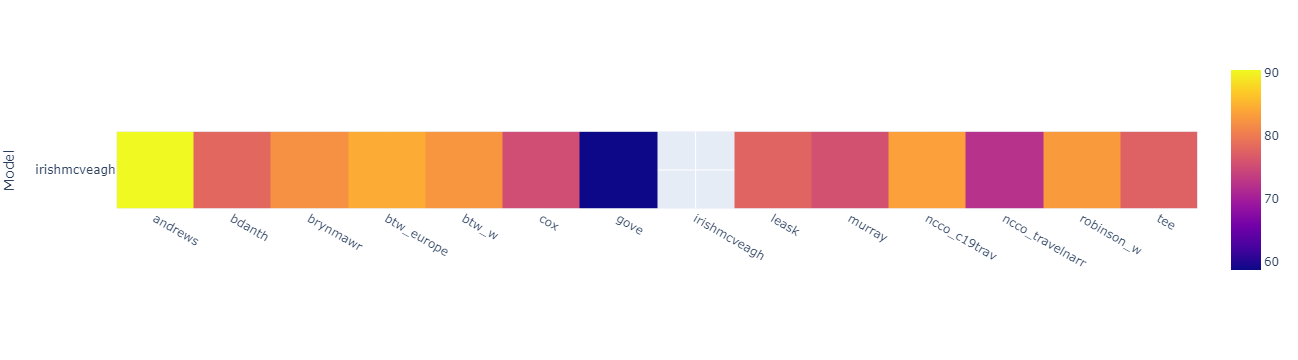

In [23]:
fig = px.imshow(compTotalsdf.loc[['irishmcveagh'], bibSourceList])

fig.show()

In [24]:
compTotalsdf.loc[['irishmcveagh'], bibSourceList].T.sort_values('irishmcveagh', ascending=True)

Model            irishmcveagh
gove                     58.7
ncco_travelnarr          72.2
cox                      75.3
murray                   75.7
tee                      77.4
leask                    77.7
bdanth                   78.0
brynmawr                 82.1
btw_w                    82.5
robinson_w               82.9
ncco_c19trav             83.4
btw_europe               84.3
andrews                  90.4
irishmcveagh              NaN

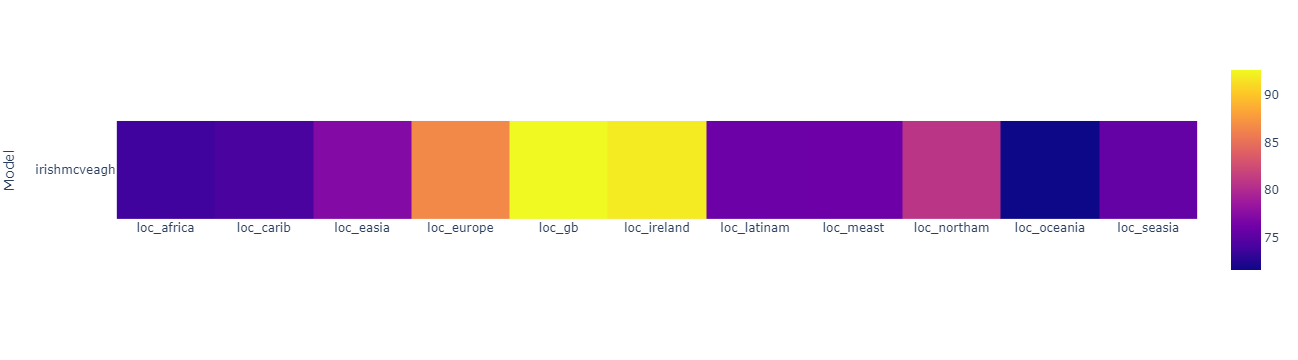

In [25]:
fig = px.imshow(compTotalsdf.loc[['irishmcveagh'], compTotalsdf.columns.str.contains('loc')])

fig.show()

In [26]:
compTotalsdf.loc[['irishmcveagh'], compTotalsdf.columns.str.contains('loc')].T.sort_values('irishmcveagh')

Model        irishmcveagh
loc_oceania          71.6
loc_africa           73.7
loc_carib            74.2
loc_seasia           75.6
loc_latinam          75.9
loc_meast            76.0
loc_easia            77.2
loc_northam          80.8
loc_europe           86.6
loc_ireland          91.9
loc_gb               92.6

In [27]:
compTotalsdf.loc[['cox'], bibSourceList].T

Model             cox
andrews          75.5
bdanth           82.0
brynmawr         83.9
btw_europe       75.1
btw_w            75.2
cox               NaN
gove             70.8
irishmcveagh     75.3
leask            79.3
murray           78.3
ncco_c19trav     77.6
ncco_travelnarr  76.1
robinson_w       73.9
tee              76.7

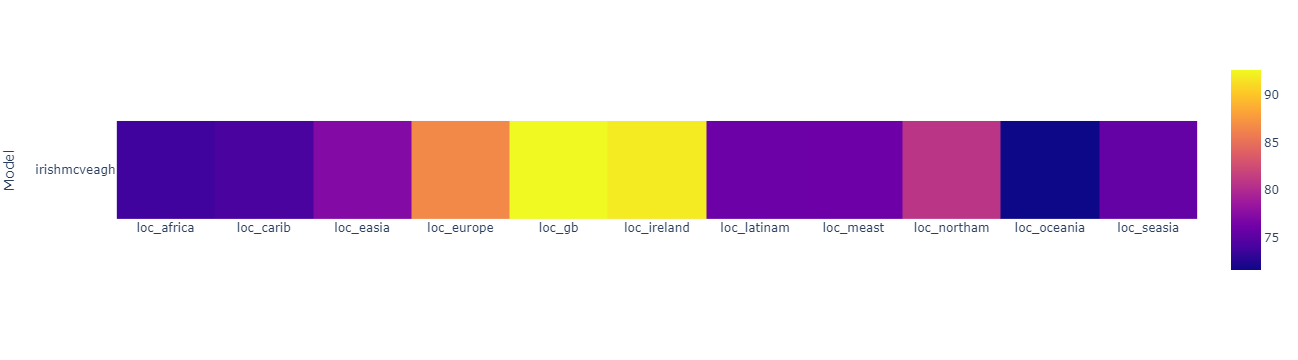

In [28]:
fig = px.imshow(compTotalsdf.loc[['irishmcveagh'], compTotalsdf.columns.str.contains('loc')])

fig.show()

## Imaginary Fiction

In [29]:
imagCategories = ['fictitious', 'gove', 'lcsh_imaginary', 'lcsh_fiction',  'imagfiction','nontravel_fiction']

In [30]:
imagPath = modelBasePath + 'lcsh\\imagfiction\\'
imagPath_1 = imagPath + 'imagfiction.1\\'

In [31]:
allaccdf[allaccdf.Model.isin(imagCategories)]

Model        bestaccuracy  average_bestaccuracy  total files
7          fictitious  [0.86, 0.92, 0.91]                  89.7         38.0
14       lcsh_fiction   [0.91, 0.9, 0.92]                  91.0         84.0
16     lcsh_imaginary    [0.9, 0.93, 0.9]                  91.0         67.0
11        imagfiction  [0.91, 0.91, 0.92]                  91.3        179.0
35  nontravel_fiction  [0.93, 0.93, 0.92]                  92.7        218.0
10               gove  [0.95, 0.93, 0.94]                  94.0         85.0

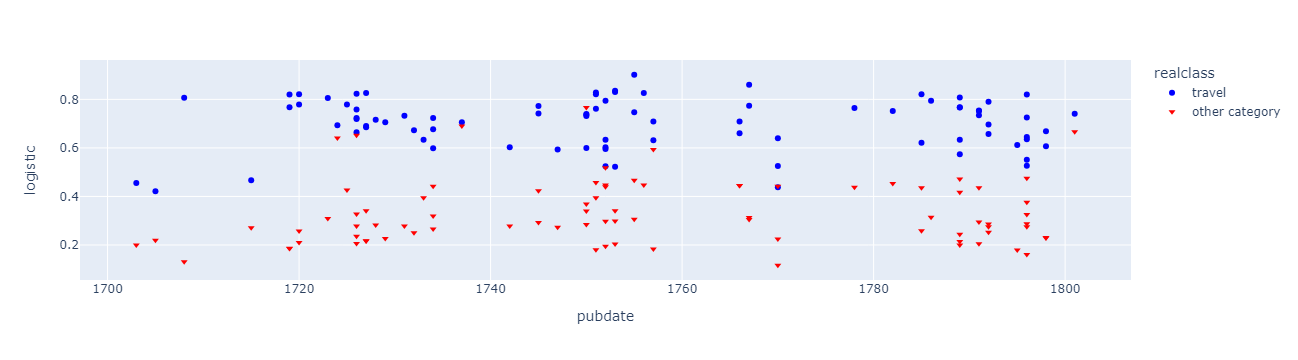

In [32]:
# to see individual dfs:
df = pd.read_csv(modelBasePath + 'allbibs/allbibs.1/gove.csv')
makefig(df)

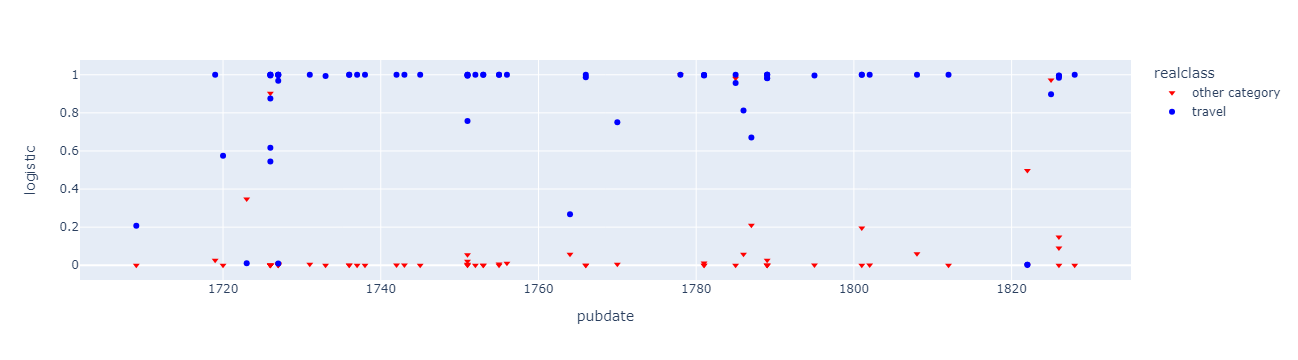

In [33]:
df = pd.read_csv(imagPath_1 + 'lcsh_imaginary.csv')
makefig(df)

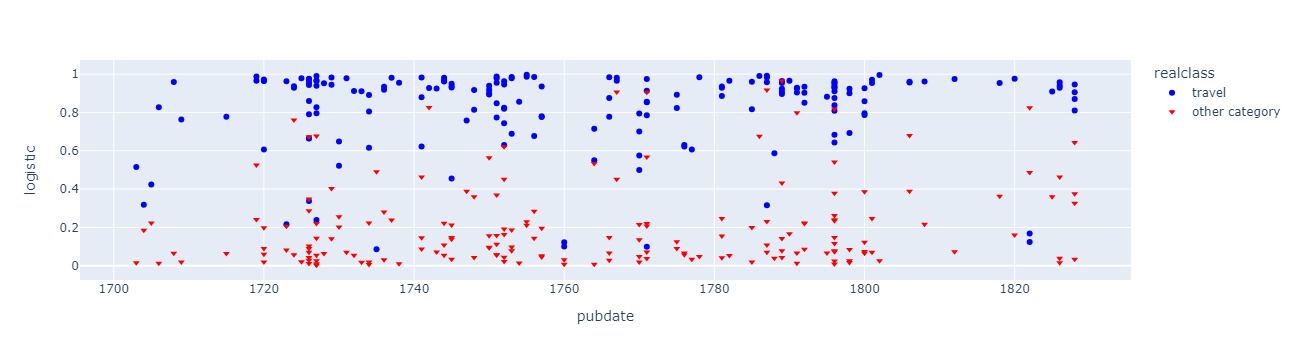

In [34]:
df = pd.read_csv(imagPath_1 + 'imagfiction.csv')
makefig(df)

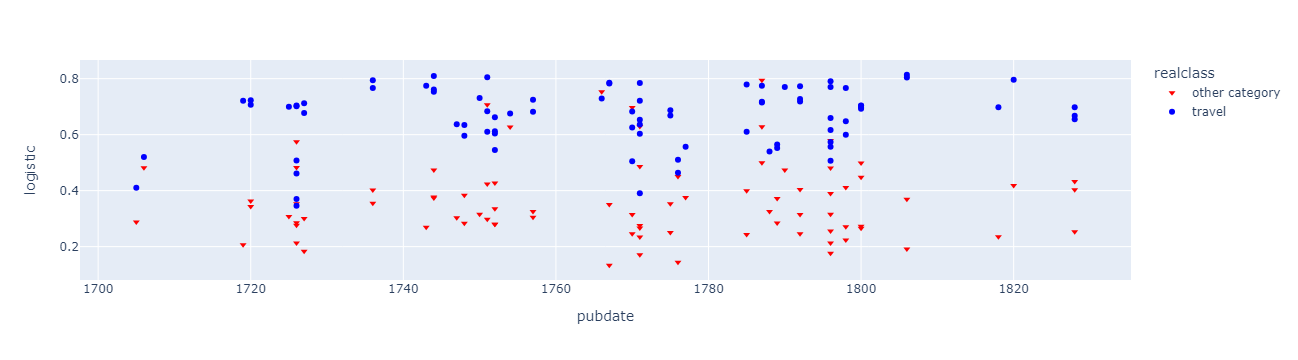

In [35]:
df = pd.read_csv(imagPath_1 + 'lcsh_fiction.csv')
makefig(df)

In [36]:
imagTotalsdf = compTotalsdf.loc[imagCategories, imagCategories].copy()
imagTotalsdf
# imagTotalsdf.to_csv('finalbibs/imagtotals.csv')

fictitious  gove  lcsh_imaginary  lcsh_fiction  \
Model                                                               
fictitious                NaN  85.4            84.6          81.1   
gove                     85.4   NaN            90.6          92.3   
lcsh_imaginary           84.6  90.6             NaN          88.3   
lcsh_fiction             81.1  92.3            88.3           NaN   
imagfiction              85.3  90.7            92.9          90.9   
nontravel_fiction        76.7  89.6            83.9          88.8   

                   imagfiction  nontravel_fiction  
Model                                              
fictitious                85.3               76.7  
gove                      90.7               89.6  
lcsh_imaginary            92.9               83.9  
lcsh_fiction              90.9               88.8  
imagfiction                NaN               86.0  
nontravel_fiction         86.0                NaN

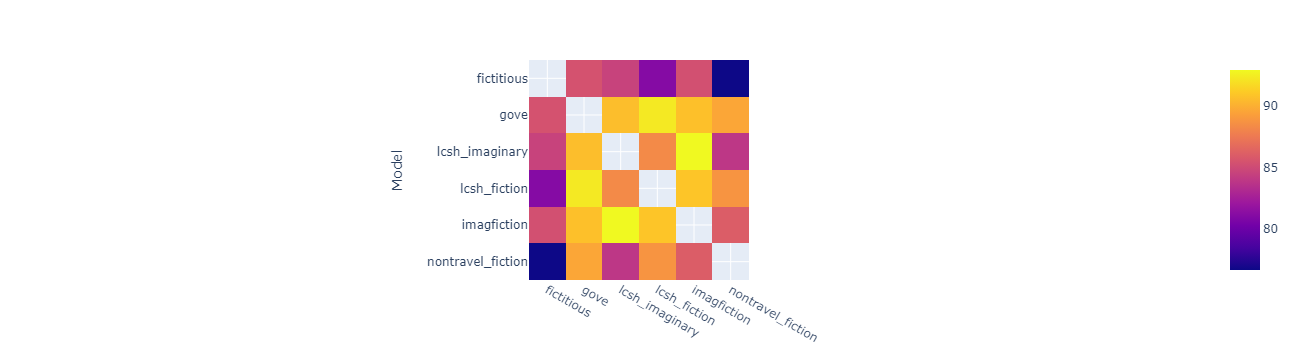

In [37]:
fig = px.imshow(imagTotalsdf.round(2))
fig.show()


### Special Titles

In [38]:
allpredictions = pd.read_csv(modelBasePath+'\\surprises and predictions\\titlepredictions_averages.csv', encoding='utf8')

In [39]:
imagTitleSearch = ['millenium hall', 'sentimental journey through france', 'humphry clinker',
                   'travels into several remote nations of the world']
# imagTitleSearch = ['sentimental']
imagineTitles = allpredictions[allpredictions['title'].str.lower().str.contains('|'.join(imagTitleSearch), case=False)].copy()

imagineTitles[['docid','author','title','date']+imagCategories+['alltravel', 'lcsh_traveltag', 'btw_w', 'robinson_w']].sort_values('author').round(1)

docid                   author  \
36  dul1.ark+=13960=t4mk7258x             Scott, Sarah   
18                 0509400601  Smollett, Tobias George   
19                 0509400602  Smollett, Tobias George   
20                 0509400603  Smollett, Tobias George   
31                 1269300201         Sterne, Laurence   
32                 1269300202         Sterne, Laurence   
24                 0647100501          Swift, Jonathan   
25                 0647100502          Swift, Jonathan   
38         mdp.39015078568592          [unlisted-twdb]   

                                                title  date  fictitious  gove  \
36  A description of Millenium Hall, and the count...  1762        95.2  86.0   
18  The expedition of Humphry Clinker. By the auth...  1771        50.6  67.5   
19  The expedition of Humphry Clinker. By the auth...  1771        65.4  75.3   
20  The expedition of Humphry Clinker. By the auth...  1771        71.4  77.1   
31  A sentimental journey through France and Italy...  1768        65.9  75.4   
32  A sentimental journey through France and Italy...  1768        68.8  81.9   
24  Travels into several remote nations of the wor...  1726        96.6  87.0   
25  Travels into several remote nations of the wor...  1726        97.3  84.7   
38  Travels into several remote nations of the wor...  1727        98.0  92.4   

    lcsh_imaginary  lcsh_fiction  imagfiction  nontravel_fiction  alltravel  \
36            99.2          85.6         96.3               96.9       36.4   
18            80.4          71.2         83.8               76.1       41.0   
19            86.1          79.1         88.2               83.8       50.8   
20            93.8          78.5         89.8               84.6       67.2   
31            94.9          74.7         72.2               86.3       43.8   
32            96.9          76.7         78.9               92.0       55.9   
24           100.0          86.6         97.6               77.0       86.8   
25           100.0          85.9         98.3               79.8       84.2   
38           100.0          90.7         99.6               97.1       94.3   

    lcsh_traveltag  btw_w  robinson_w  
36            28.2   29.2        23.2  
18            40.7   19.9        43.0  
19            49.6   22.0        36.8  
20            62.8   34.7        52.0  
31            38.1   25.7        59.5  
32            43.6   26.4        71.2  
24            83.9   29.9        79.7  
25            77.3   25.0        55.0  
38            91.2   46.8        79.7

## Poetry and History

Let's look at these other two terms that are interesting in connection with travel writing.

In [40]:
poetryPath = modelBasePath + 'lcsh\\poetry\\'
poetryPath_1 = poetryPath + 'poetry.1\\'

In [41]:
poetryCategories = ['lcsh_title_poetry', 'nontravel_poetry']

In [42]:
allaccdf[allaccdf.Model.isin(poetryCategories)]

Model        bestaccuracy  average_bestaccuracy  total files
18  lcsh_title_poetry  [0.89, 0.91, 0.89]                  89.7         56.0
37   nontravel_poetry  [0.93, 0.94, 0.93]                  93.3        300.0

In [43]:
poetryTotalsdf = compTotalsdf.loc[['lcsh_title_poetry'], poetryCategories+bibSourceList+genList].copy()
poetryTotalsdf.T.sort_values('lcsh_title_poetry')

Model              lcsh_title_poetry
gove                            60.4
leask                           60.5
bdanth                          63.3
cox                             64.2
robinson_w                      65.8
tee                             66.9
alltravel                       68.0
lcsh_traveltag                  69.5
brynmawr                        69.7
murray                          70.4
btw_europe                      70.8
btw_w                           71.2
irishmcveagh                    72.4
ncco_travelnarr                 73.1
ncco_c19trav                    73.6
andrews                         74.3
nontravel_poetry                84.5
lcsh_title_poetry                NaN

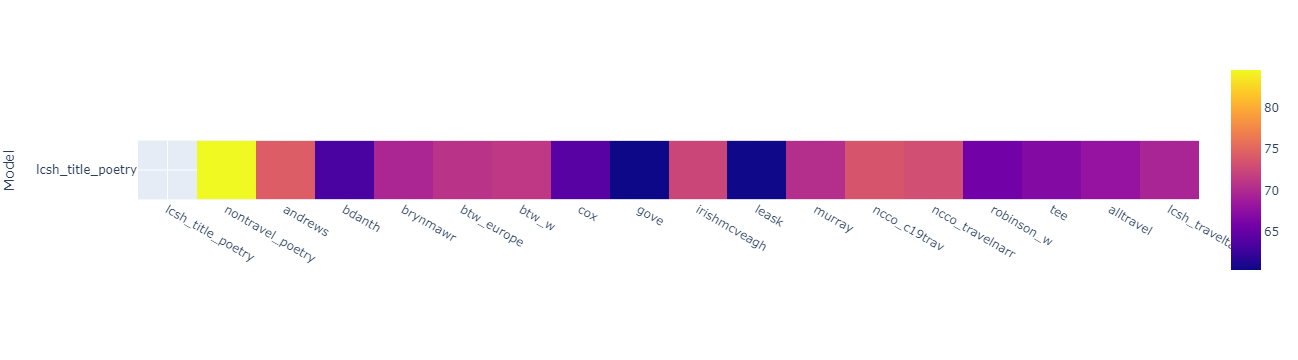

In [44]:
fig = px.imshow(poetryTotalsdf.round(2))
fig.show()


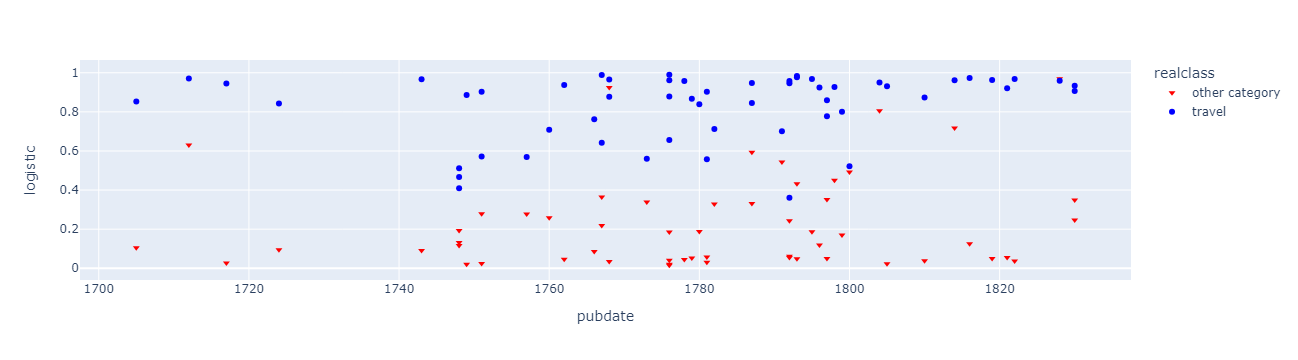

In [45]:
df = pd.read_csv(modelBasePath + 'lcsh\\poetry\\poetry.1\\' + 'lcsh_title_poetry.csv')
makefig(df)

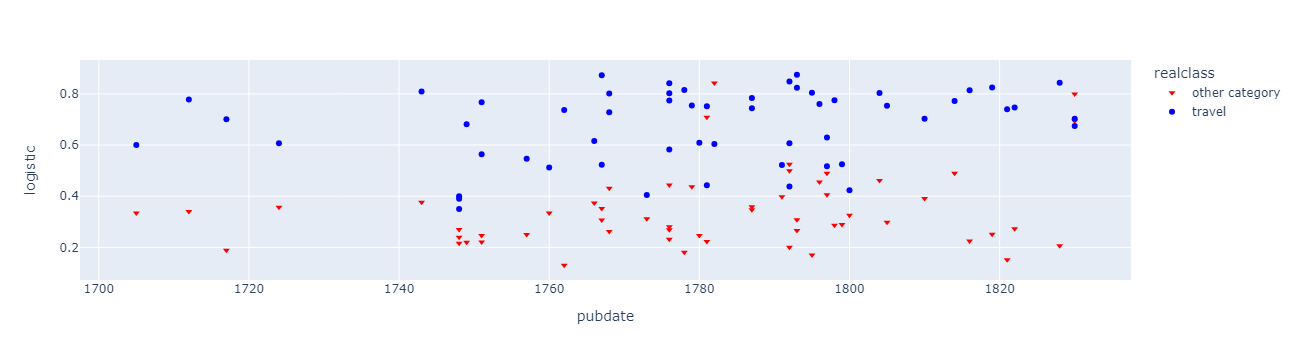

In [46]:
df = pd.read_csv(modelBasePath + 'lcsh\\poetry\\poetry.2\\' + 'lcsh_title_poetry.csv')
makefig(df)

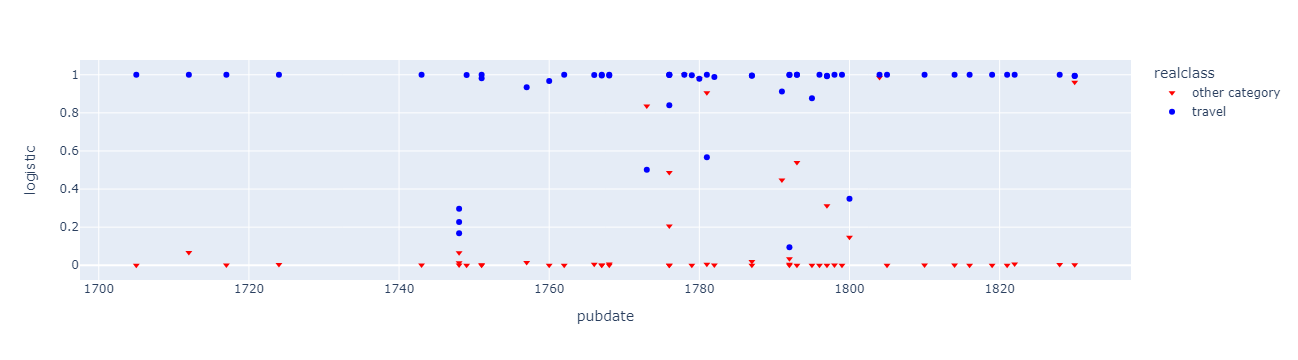

In [47]:
df = pd.read_csv(modelBasePath + 'lcsh\\poetry\\poetry.3\\' + 'lcsh_title_poetry.csv')
makefig(df)

### History

In [48]:
histCategories = ['lcsh_history', 'nontravel_history', 'lcsh_antiquities']

In [49]:
allaccdf[allaccdf.Model.isin(histCategories)]

Model        bestaccuracy  average_bestaccuracy  total files
36  nontravel_history  [0.78, 0.79, 0.79]                  78.7        300.0
15       lcsh_history   [0.88, 0.9, 0.86]                  88.0        300.0
13   lcsh_antiquities    [0.9, 0.9, 0.92]                  90.7        279.0

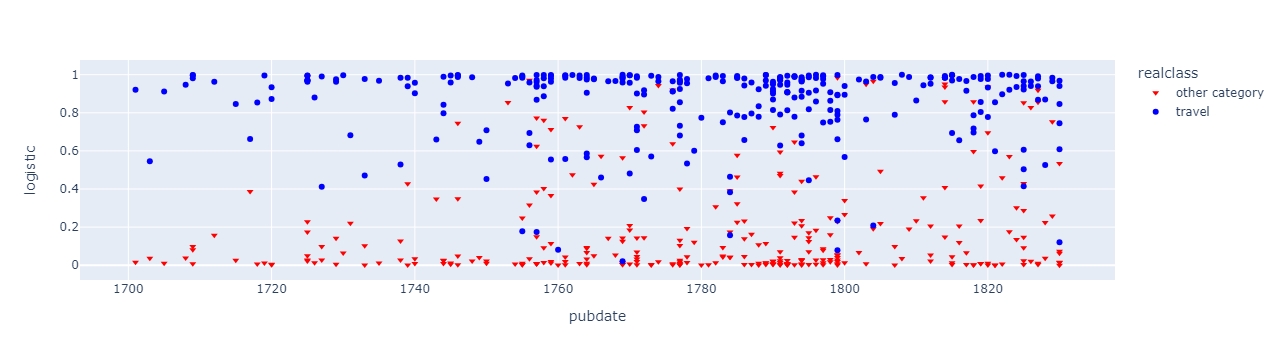

In [50]:
df = pd.read_csv(modelBasePath + 'lcsh\\history\\history.1\\' + 'lcsh_history.csv')
makefig(df)

In [51]:
historyTotalsdf = compTotalsdf.loc[['lcsh_history', 'lcsh_antiquities', 'nontravel_history'], bibSourceList+['alltravel']].copy()
historyTotalsdf.T.sort_values('lcsh_history')

Model            lcsh_history  lcsh_antiquities  nontravel_history
gove                     67.4              54.3               56.3
robinson_w               69.7              71.8               51.7
btw_europe               70.9              76.3               51.1
andrews                  71.0              80.7               51.1
irishmcveagh             71.9              79.7               50.3
ncco_travelnarr          73.1              74.9               55.4
btw_w                    74.1              74.6               54.3
tee                      74.1              68.6               54.9
murray                   76.6              68.6               54.2
ncco_c19trav             78.3              80.7               56.7
leask                    78.6              77.0               59.5
bdanth                   78.7              75.6               56.3
brynmawr                 84.8              83.1               58.6
cox                      84.8              78.4               63.2
alltravel                86.1              83.4               62.2

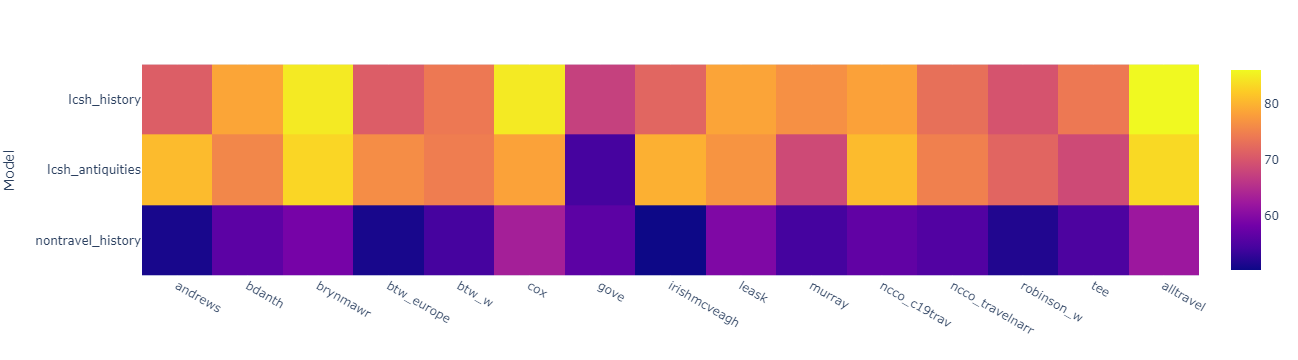

In [52]:
fig = px.imshow(historyTotalsdf.round(2))
fig.show()



# Locations

In [53]:
locpath = modelBasePath + 'locations//'

In [54]:
locdf = accuracy_summary(locpath)
locdf.sort_values('average_bestaccuracy')

Model        bestaccuracy  average_bestaccuracy  total files
1     loc_carib  [0.77, 0.73, 0.86]                  78.7         28.0
9   loc_oceania  [0.87, 0.87, 0.87]                  87.0         15.0
10   loc_seasia  [0.94, 0.89, 0.91]                  91.3         48.0
8   loc_northam  [0.93, 0.93, 0.93]                  93.0        269.0
7     loc_meast  [0.93, 0.93, 0.94]                  93.3         73.0
6   loc_latinam  [0.94, 0.94, 0.93]                  93.7         75.0
5   loc_ireland  [0.93, 0.95, 0.93]                  93.7         30.0
2     loc_easia   [0.9, 0.96, 0.96]                  94.0         34.0
4        loc_gb  [0.95, 0.94, 0.94]                  94.3        300.0
3    loc_europe  [0.96, 0.96, 0.95]                  95.7        299.0
0    loc_africa  [0.97, 0.98, 0.97]                  97.3        104.0

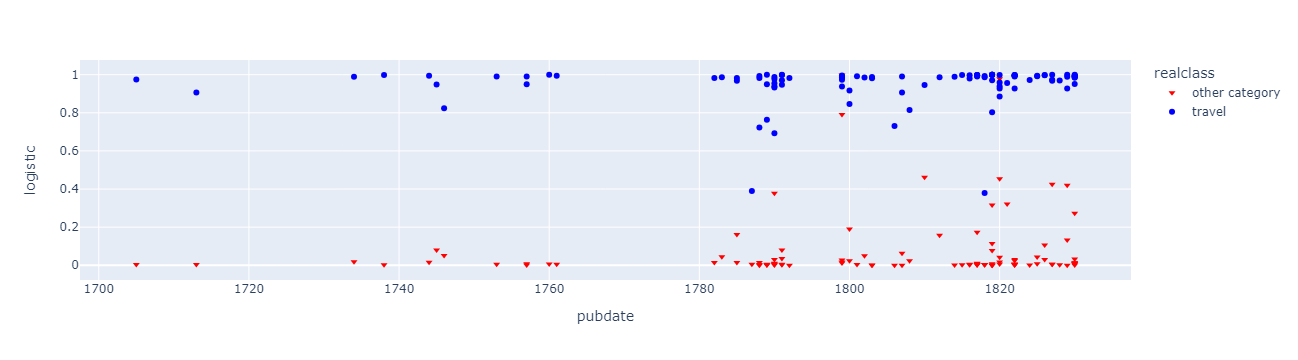

In [55]:
locdf_1 = pd.read_csv(locpath +'location.3\\loc_africa.csv')
makefig(locdf_1)

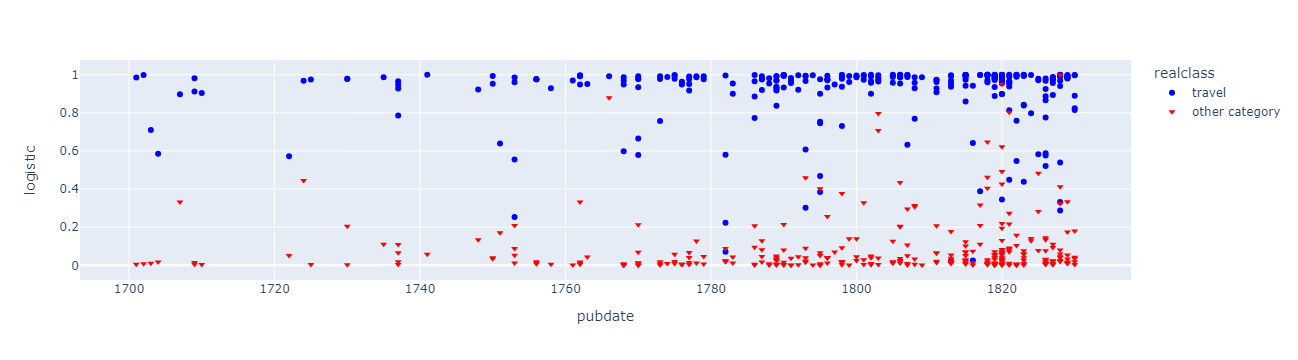

In [56]:
locdf_2 = pd.read_csv(locpath +'location.1\\loc_europe.csv')
makefig(locdf_2)

In [57]:
locList = locdf['Model'].tolist()

In the small collection of titles about the Caribbean, the low accuracy is helped along by *Whartoniana* (0595000601) with its collection of verses, and an economic tract---with no mention of the Caribbean beyond the South Sea bubble---entitled *The Present state of the national debt* (1447101600). Oceania, despite being an even smaller corpus, is still more accuarte, at 87%, and from there, the other locations are all above 91%. Titles describing Africa are relatively easy for models to predict, with one of the highest accuracies across all models at 97.3%; European models, despite including locations ranging from Sweden to Italy, also have high accuracies.

In [58]:
locCategories = accuracy_summary(locpath)['Model'].tolist() + genList
locTotalsdf = compTotalsdf.loc[locCategories, locCategories].copy()

In [59]:
locTotalsdf.drop(genList, axis=1).mean().sort_values().round(1)

loc_carib      77.4
loc_gb         79.2
loc_oceania    79.6
loc_latinam    82.6
loc_ireland    82.8
loc_northam    82.9
loc_meast      83.7
loc_seasia     84.5
loc_easia      85.0
loc_europe     85.1
loc_africa     86.2
dtype: float64

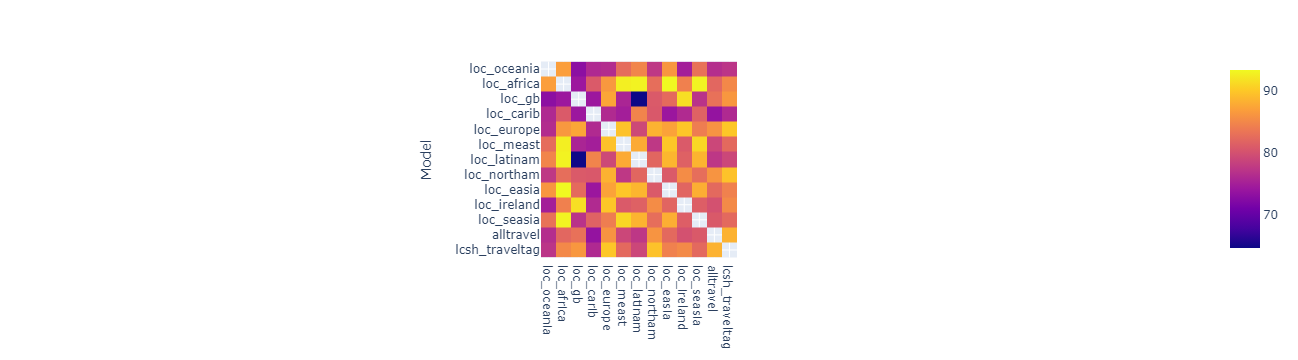

In [60]:
fig = px.imshow(locTotalsdf.round(1))
fig.show()

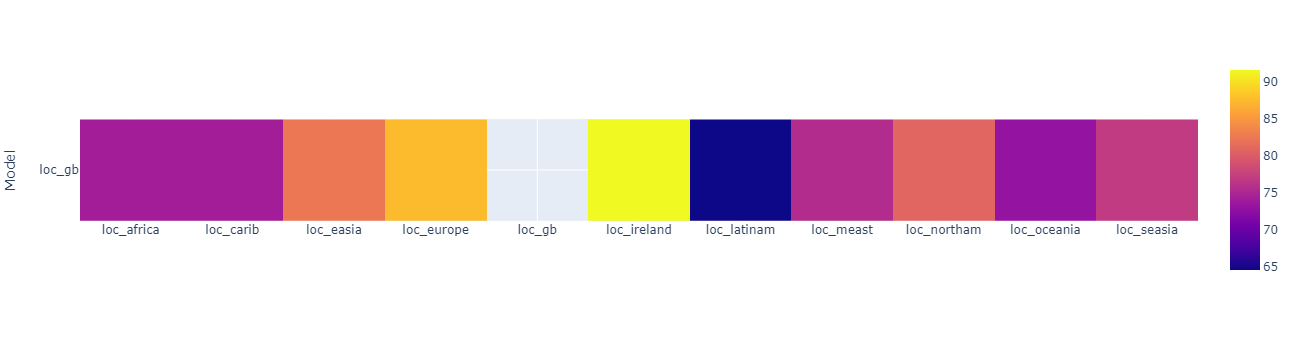

In [61]:
fig = px.imshow(compTotalsdf.loc[['loc_gb'], compTotalsdf.columns.str.contains('loc')].round(1))
fig.show()

In [62]:
compTotalsdfList.loc[['loc_gb'], compTotalsdfList.columns.str.contains('loc')]


loc_africa           loc_carib           loc_easia  \
Model                                                                
loc_gb  [71.8, 76.3, 74.4]  [73.8, 74.8, 74.1]  [80.7, 83.5, 83.0]   

                loc_europe loc_gb         loc_ireland         loc_latinam  \
Model                                                                       
loc_gb  [87.7, 87.9, 86.8]    NaN  [91.5, 91.3, 91.9]  [61.6, 66.9, 65.2]   

                 loc_meast         loc_northam         loc_oceania  \
Model                                                                
loc_gb  [75.8, 76.9, 74.2]  [80.2, 82.8, 79.7]  [70.8, 74.1, 74.1]   

                loc_seasia  
Model                       
loc_gb  [76.0, 77.9, 77.2]

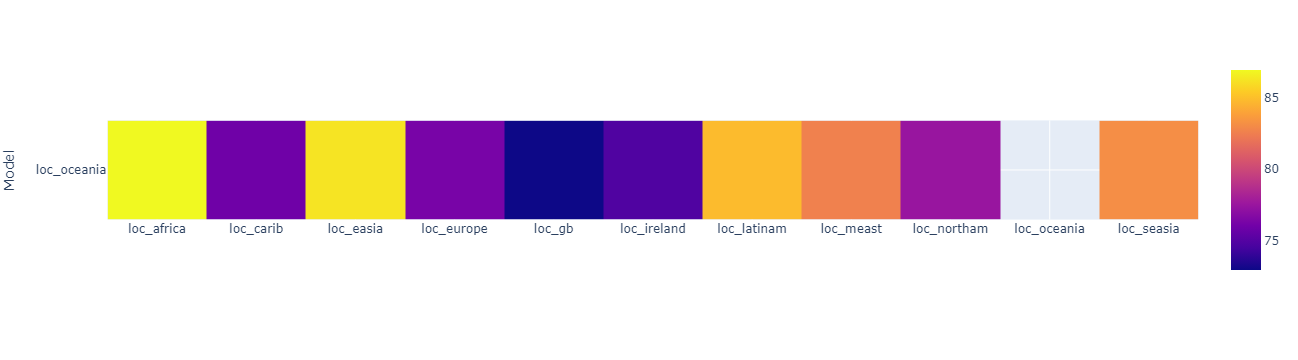

In [63]:
fig = px.imshow(compTotalsdf.loc[['loc_oceania'], compTotalsdf.columns.str.contains('loc')].round(1))
fig.show()

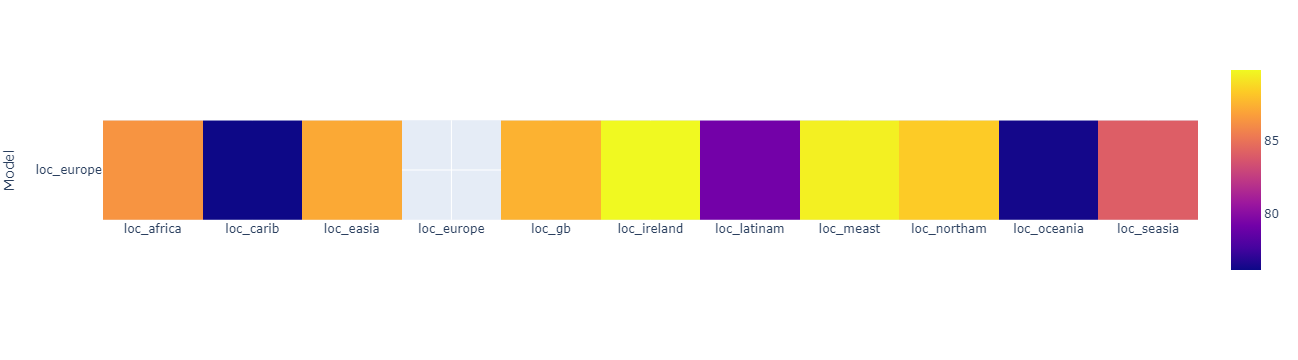

In [64]:
fig = px.imshow(compTotalsdf.loc[['loc_europe'], compTotalsdf.columns.str.contains('loc')].round(1))
fig.show()

The comparisons are far more interesting, however. (Note that for the location tags, no travel titles overlap in the training corpus, so the travel portion of the models are completely individual.) There are some distinct patterns that appear. Continuing our discussion of Great Britain and Ireland, the model of the descriptions and travel titles of those islands are very similar, at 92.9% accuracy. The other locations similar to Great Brtiain are Europe, at 85 percent, and North America at 83.4%, indicating connections in how writers conceived of these locations. Domestic travel in Great Britain is, however, generally more distinct from other locations, especially Oceania (nearly 50%), the Caribbean, Africa, and east Asia (all below 67%). In turn, models of Oceania are distinct from European, British, and Irish models; instead, Oceania's closest relations are east Asia (92.9%) and Africa (89.9%). 

Further questions for this section might include, for example, whether (and how) these models might have evolved over time. North America and 

Analyzing by location shifts attention away from our central question of genre, but it does influence our perspective of travel writing, drawing attention to how models of texts about different places may reveal differences in how these locations were conceptualized for a British audience, offering one way of answering Pratt's question of “How has travel and exploration writing *produced* ‘the rest of the world’ for European readerships at particular points in Europe’s [and Great Britain's] expansionist trajectory?” (4). For example, in a more in-depth study focused on individual nations, we could fine-tune our 83.6% prediction rate for European and Latin American countries to consider Pratt's assertion that "It is not surprising, then, to find...British accounts of Italy sounding like...British accounts of Brazil" (10). (The TWDB has 11 'Description and travel' titles about Brazil, and 128 on Italy.)

## Countries

I created three models of Italy and Brazil to try to answer Mary Pratt's question re imperial eyes.

In [65]:
brazil_italy_df = compTotals((modelBasePath+'\\mutual recognition\\comparisonTotals_italybrazil_averages.csv'))

In [66]:
(brazil_italy_df/100).round(1)

loc_country_italysolo  loc_country_brazilsolo  \
Model                                                                   
loc_country_braziletc                    74.8                    92.1   
loc_country_brazilsolo                   74.6                    94.2   
loc_country_italysolo                    97.7                    74.6   

                        loc_country_braziletc  
Model                                          
loc_country_braziletc                    94.2  
loc_country_brazilsolo                   92.1  
loc_country_italysolo                    74.8

## Gender



In [67]:
genderpath = modelBasePath + 'gender//'

In [68]:
genderTotalsdf = compTotalsdf.loc[['gender_au'], compTotalsdf.columns.tolist()].copy()


In [69]:
allaccdf[allaccdf.Model.isin(['btw_w', 'robinson_w','gender_au', 'gender_au_vs_non'])]

Model        bestaccuracy  average_bestaccuracy  total files
9   gender_au_vs_non  [0.86, 0.83, 0.81]                  83.3        171.0
8          gender_au   [0.89, 0.9, 0.93]                  90.7        171.0
5              btw_w  [0.92, 0.92, 0.91]                  91.7        152.0
39        robinson_w  [0.94, 0.92, 0.96]                  94.0         45.0

In [70]:
allaccdf[allaccdf.Model.isin(bibSourceList+genList +['btw_w', 'robinson_w','gender_au', 'gender_au_vs_non'])]

Model        bestaccuracy  average_bestaccuracy  total files
34   ncco_travelnarr    [0.7, 0.9, 0.85]                  81.7         10.0
9   gender_au_vs_non  [0.86, 0.83, 0.81]                  83.3        171.0
6                cox  [0.87, 0.88, 0.87]                  87.3        300.0
0          alltravel  [0.88, 0.86, 0.88]                  87.3        300.0
19    lcsh_traveltag     [0.9, 0.9, 0.9]                  90.0        300.0
8          gender_au   [0.89, 0.9, 0.93]                  90.7        171.0
12      irishmcveagh    [0.9, 0.94, 0.9]                  91.3         55.0
5              btw_w  [0.92, 0.92, 0.91]                  91.7        152.0
20             leask  [0.93, 0.91, 0.94]                  92.7         96.0
4         btw_europe  [0.93, 0.93, 0.93]                  93.0         74.0
1            andrews  [0.94, 0.92, 0.93]                  93.0         63.0
32            murray  [0.94, 0.93, 0.94]                  93.7        118.0
33      ncco_c19trav  [0.94, 0.94, 0.93]                  93.7        180.0
10              gove  [0.95, 0.93, 0.94]                  94.0         85.0
39        robinson_w  [0.94, 0.92, 0.96]                  94.0         45.0
2             bdanth  [0.93, 0.93, 0.96]                  94.0         60.0
3           brynmawr  [0.95, 0.94, 0.94]                  94.3        243.0
40               tee  [0.96, 0.96, 0.95]                  95.7         81.0

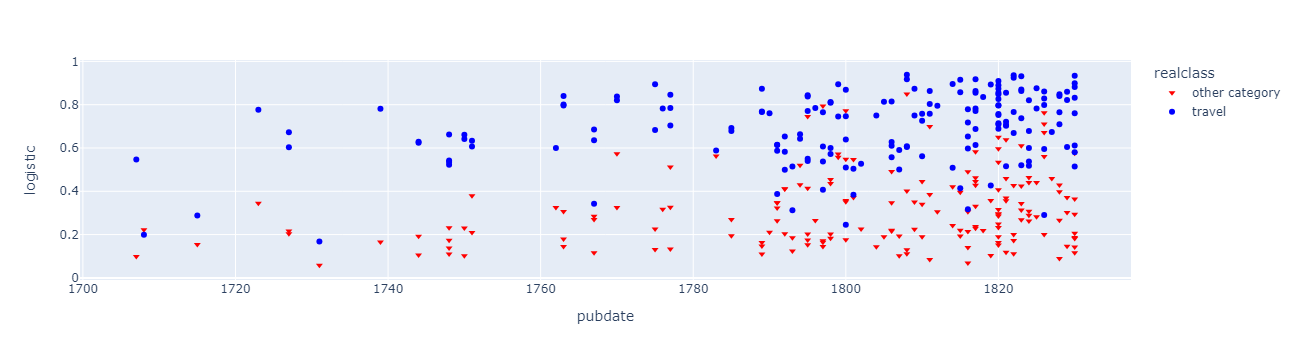

In [71]:
gender_audf = pd.read_csv(genderpath +'gender.1\\gender_au.csv')
makefig(gender_audf)

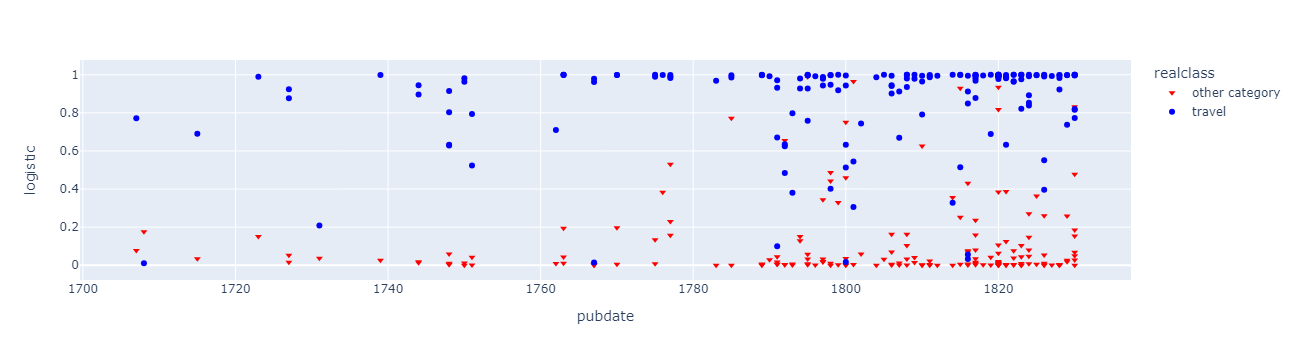

In [72]:
gender_audf = pd.read_csv(genderpath +'gender.2\\gender_au.csv')
makefig(gender_audf)

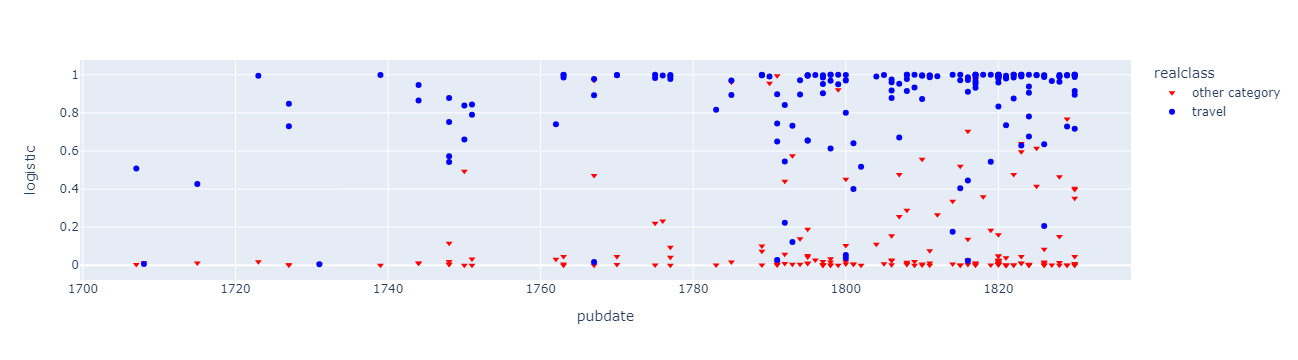

In [73]:
gender_audf = pd.read_csv(genderpath +'gender.3\\gender_au.csv')
makefig(gender_audf)

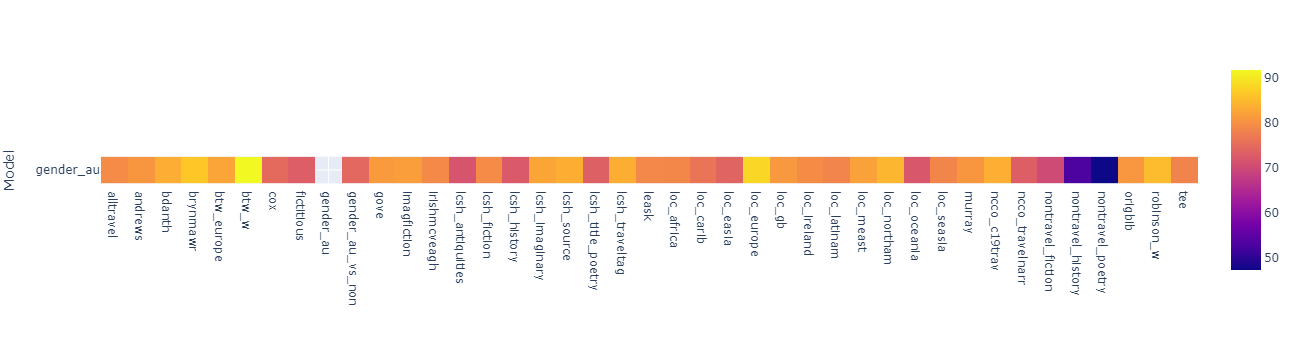

In [74]:
fig = px.imshow(genderTotalsdf)
fig.show()

In [75]:
# btw = pd.read_csv(genderpath +'gender.1\\btw_w.csv')
# makefig(btw)

In [76]:
# btw = pd.read_csv(genderpath +'gender.1\\btw_w.csv')
# makefig(btw)

In [77]:
# robdf = pd.read_csv(genderpath +'gender.1\\robinson_w.csv')
# makefig(robdf)